In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm

# 그래프 Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
mpl.rcParams['axes.unicode_minus'] = False
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mpl.rc('font',family= font_name)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Decision tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
# 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor
# 정규분포 및 회귀분석 등
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
# KNN
from sklearn.neighbors import KNeighborsRegressor
# 시계열분석
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

#스케일링
from sklearn.preprocessing import scale, minmax_scale, robust_scale
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
#선형 회귀모형
from sklearn.linear_model import LinearRegression
#변수선택법 (후진제거법)
from sklearn.feature_selection import RFE
#스케일 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

In [5]:
df_raw = pd.read_csv("/home/pirl/Statistics/Day3_0715/환율.csv", engine = "python", parse_dates = ["APPL_DATE"])
df_raw.head

<bound method NDFrame.head of     CURRENCY  APPL_DATE  STD_RATE  USD_CONV_DATE
0        CNY 2016-01-01    181.48         0.1541
1        JPY 2016-01-01    976.99         0.8294
2        USD 2016-01-01   1178.00         1.0000
3        CNY 2016-01-02    181.48         0.1541
4        JPY 2016-01-02    976.99         0.8294
5        USD 2016-01-02   1178.00         1.0000
6        CNY 2016-01-03    181.48         0.1541
7        JPY 2016-01-03    976.99         0.8294
8        USD 2016-01-03   1178.00         1.0000
9        CNY 2016-01-04    181.10         0.1540
10       JPY 2016-01-04    992.62         0.8384
11       USD 2016-01-04   1184.00         1.0000
12       CNY 2016-01-05    181.94         0.1530
13       JPY 2016-01-05    993.00         0.8380
14       USD 2016-01-05   1185.00         1.0000
15       CNY 2016-01-06    182.61         0.1533
16       JPY 2016-01-06   1005.06         0.8439
17       USD 2016-01-06   1191.00         1.0000
18       CNY 2016-01-07    183.03      

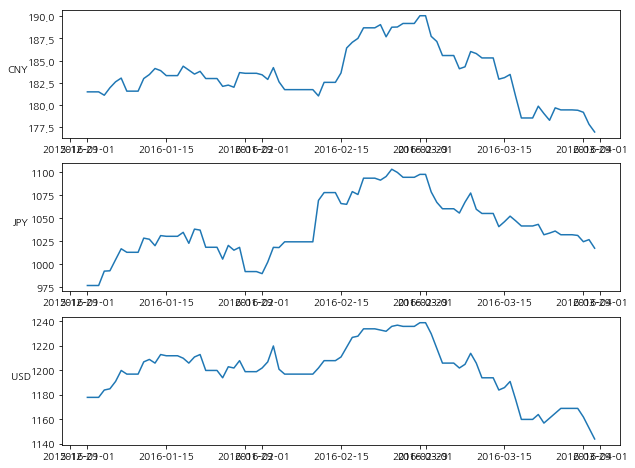

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,8))
for (ax, idx, currency) in zip([ax1, ax2, ax3], [311,312,313], ["CNY","JPY","USD"]) :
    ax.plot ("APPL_DATE","STD_RATE",data = df_raw[df_raw["CURRENCY"] == currency])
    ax.set_ylabel(currency, rotation = 0, labelpad = 10)

In [11]:
df_CNY = df_raw[df_raw["CURRENCY"] == "CNY"].set_index("APPL_DATE")
df_CNY.drop(["CURRENCY","USD_CONV_DATE"], axis=1, inplace = True)
df_JPN = df_raw[df_raw["CURRENCY"] == "JPY"].set_index("APPL_DATE")
df_JPN.drop(["CURRENCY","USD_CONV_DATE"], axis=1, inplace = True)
df_USD = df_raw[df_raw["CURRENCY"] == "USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY","USD_CONV_DATE"], axis=1, inplace = True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [14]:
# Train & Test 데이터 분할 : 비율 기준 mask 지정
train_size = 0.8
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [15]:
## mask를 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]

print("shape of train data:{}".format(df_CNY_train.shape))
print("shape of test data:{}".format(df_CNY_test.shape))

shape of train data:(73, 1)
shape of test data:(18, 1)


In [18]:
df_CNY_train = df_CNY[df_CNY.index<="2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index>"2016-03-22"]
df_CNY_test.head()


,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


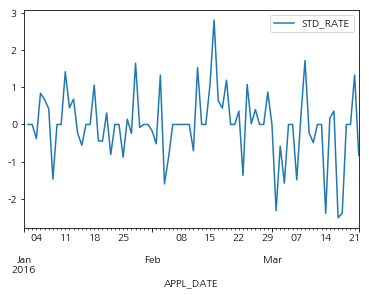

In [20]:
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

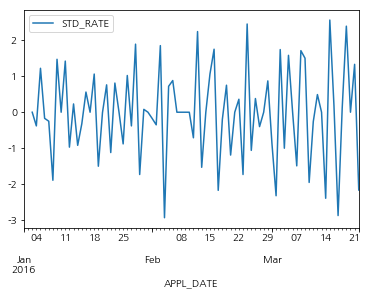

In [25]:
df_CNY_diff2 = df_CNY_train - 2*(df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

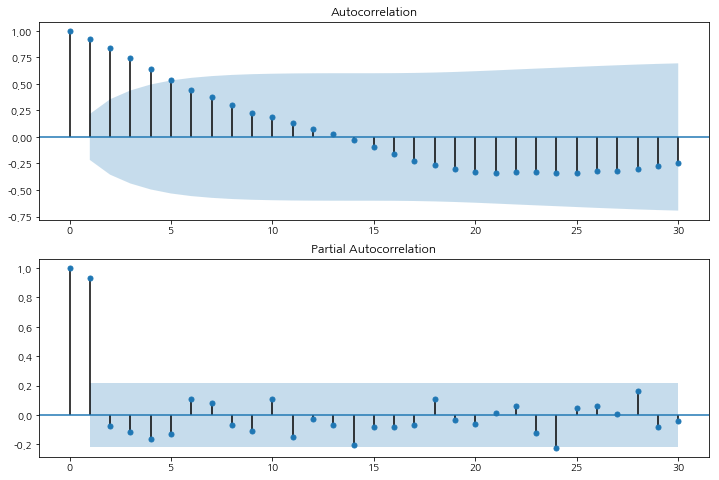

In [28]:
lag_size = 30
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

fig = plot_acf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax1)
ax2 = fig.add_subplot(212)

fit = plot_pacf(df_CNY_train["STD_RATE"], lags = lag_size, ax=ax2)

In [32]:
ts_model_cny = ARIMA(df_CNY_train, order=(1,2,0))

ts_result_cny = ts_model_cny.fit(trend = "c", full_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Fri, 19 Jul 2019   AIC                            253.025
Time:                        15:44:44   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

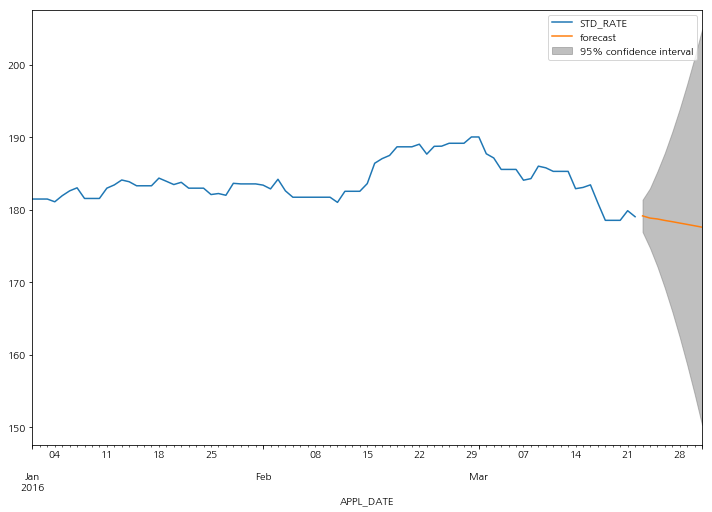

In [34]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))
ax = df_CNY_train.plot(ax=ax)
fig = ts_result_cny.plot_predict(start = start_time, end=end_time, ax=ax, plot_insample = False)

In [35]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict (start = start_time, end = end_time, typ = 'levels')
df_merge = df_CNY
df_merge["예측값"] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476897
2016-01-05,181.94,180.883667


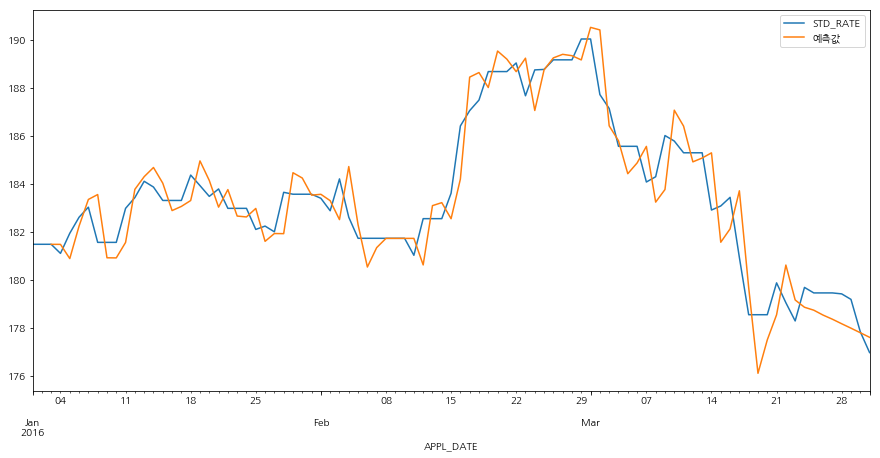

In [36]:
df_merge.plot(y=["STD_RATE", "예측값"], figsize = (15,7))